In [1]:
# HIDDEN
from datascience import *
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')
import numpy as np

In [3]:
# Read in data from health records survey as a raw table
# Public data from the UC Michigan Institute for Social Research
# Health and Retirement Survey - rsonline.isr.umich.edu
#
hrec06 = Table.read_table("./data/hrsextract06.csv")
hrec06

hhidpn,r8agey_m,ragender,raracem,rahispan,raedyrs,h8cpl,h8atota,rayshlt,r8shlt,r8expyrs,r8cesd,r8bpavgs,r8bpavgp,r8smoken,r8mdactx,r8weightbio,r8weight,r8heightbio,r8height
3010,70,1,1,0,12,1,914000,3,3,21.5,0,140,58,0,4,74.1623,71.6672,1.64465,1.6256
3020,67,2,1,0,16,1,914000,1,3,23.7,0,139,72,0,1,66.9048,65.317,1.61925,1.6256
10003030,50,2,1,0,16,0,12000,3,5,47.5,4,124,98,0,2,64.4101,58.9667,1.5494,1.5748
10004010,66,1,1,0,16,1,1.832e+06,1,4,7,1,130,74,0,2,101.605,102.511,1.8415,1.8542
10004040,60,2,1,0,12,1,1.832e+06,1,2,28.25,0,125,67,0,2,77.3374,77.1103,1.6383,1.651
10013010,68,1,1,0,12,0,50,1,3,16.5,2,125,67,0,5,110.223,108.862,1.7272,1.7272
10038010,70,1,1,0,16,1,2.5e+06,2,2,22.5,1,107,52,0,2,73.4819,74.8423,1.70815,1.7526
10038040,63,2,1,0,16,1,2.5e+06,1,1,27.05,1,112,70,0,2,65.3173,64.4098,1.67005,1.6764
10050010,64,2,3,0,17,0,664066,1,2,27.025,1,136,90,0,5,75.9767,68.0385,1.5875,1.6256
10059020,70,2,1,0,16,1,1.2405e+07,2,3,19.5,0,112,54,1,2,58.967,57.6059,1.6637,1.6764


## Indirection

They say "all problems in computer science can be solved with an extra level of indirection." 
It certainly provides some real leverage in data wrangling.  Rather than write a bunch of spaghetti
code, we will build a table that defines the transformation we would like to perform on the
raw data in order to have something cleaner to work with.  In this we can map the indecipherable identifiers
into something more understandable; we can establish formatters; we can translate field encodings into
clear mnemonics, and so on.

We need a tool for finding elements in the translation table; that's `table_lookup`.  Then we can
build our mapping tool, `map_raw_table`.

In [28]:
health_map = Table(["raw label", "label", "encoding", "Description"]).with_rows(
       [["hhidpn",  "id", None, "identifier"],
        ["r8agey_m", "age", None, "age in years in wave 8"],
        ["ragender", "gender", ['male','female'], "1 = male,  2 = female)"],
        ["raracem",  "race",   ['white','black','other'], "(1 = white,  2 = black,  3 = other)"],
        ["rahispan", "hispanic",  None, "(1 = yes)"],
        ["raedyrs",  "education", None, "education in years"],
        ["h8cpl",    "couple",    None, "in a couple household (1 = yes)"],
        ["r8bpavgs", "blood pressure", None,"average systolic BP"],
        ["r8bpavgp", "pulse", None, "average pulse"],
        ["r8smoken", "smoker",None, "currently smokes cigarettes"],
        ["r8mdactx", "exercise", None, "frequency of moderate exercise (1=everyday, 2=>1perweek, 3=1perweek, 4=1-3permonth\
, 5=never)"],
        ["r8weightbio", "weight", None, "objective weight in kg"],
        ["r8heightbio","height", None, "objective height in m"]])
health_map

raw label,label,encoding,Description
hhidpn,id,None,identifier
r8agey_m,age,None,age in years in wave 8
ragender,gender,"['male', 'female']","1 = male, 2 = female)"
raracem,race,"['white', 'black', 'other']","(1 = white, 2 = black, 3 = other)"
rahispan,hispanic,None,(1 = yes)
raedyrs,education,None,education in years
h8cpl,couple,None,in a couple household (1 = yes)
r8bpavgs,blood pressure,None,average systolic BP
r8bpavgp,pulse,None,average pulse
r8smoken,smoker,None,currently smokes cigarettes


In [29]:
def table_lookup(table,key_col,key,map_col):
    row = np.where(table[key_col]==key)
    if len(row[0]) == 1:
        return table[map_col][row[0]][0]
    else:
        return -1

In [30]:
def map_raw_table(raw_table,map_table):
    mapped = Table()
    for raw_label in raw_table :
        if raw_label in map_table["raw label"] :
            new_label = table_lookup(map_table,'raw label',raw_label,'label')
            encoding = table_lookup(map_table,'raw label',raw_label,'encoding')
            if encoding is None :
                mapped[new_label] = raw_table[raw_label]
            else:
                mapped[new_label] = raw_table.apply(lambda x: encoding[x-1], raw_label)
    return mapped

In [31]:
# create a more usable table by mapping the raw to finished
health = map_raw_table(hrec06,health_map)
health

id,age,gender,race,hispanic,education,couple,blood pressure,pulse,smoker,exercise,weight,height
3010,70,male,white,0,12,1,140,58,0,4,74.1623,1.64465
3020,67,female,white,0,16,1,139,72,0,1,66.9048,1.61925
10003030,50,female,white,0,16,0,124,98,0,2,64.4101,1.5494
10004010,66,male,white,0,16,1,130,74,0,2,101.605,1.8415
10004040,60,female,white,0,12,1,125,67,0,2,77.3374,1.6383
10013010,68,male,white,0,12,0,125,67,0,5,110.223,1.7272
10038010,70,male,white,0,16,1,107,52,0,2,73.4819,1.70815
10038040,63,female,white,0,16,1,112,70,0,2,65.3173,1.67005
10050010,64,female,other,0,17,0,136,90,0,5,75.9767,1.5875
10059020,70,female,white,0,16,1,112,54,1,2,58.967,1.6637


## Descriptive statistics - smoking

In [32]:
def firstQtile(x) : return np.percentile(x,25)
def thirdQtile(x) : return np.percentile(x,25)
summary_ops = (min, firstQtile, np.median, np.mean, thirdQtile, max, sum)

In [33]:
# Let's try what is the effect of smoking
smokers = health.where('smoker',1)
nosmokers = health.where('smoker',0)
print(smokers.num_rows, ' smokers')
print(nosmokers.num_rows, ' non-smokers')

893  smokers
5449  non-smokers


In [34]:
smokers.stats(summary_ops)

statistic,id,age,gender,race,hispanic,education,couple,blood pressure,pulse,smoker,exercise,weight,height
min,1.0059e+07,30,female,black,0,0,0,68,45,1,1,36.0606,1.4224
firstQtile,4.8508e+07,55,,,0,11,0,114,66,1,2,64.1833,1.6002
median,1.15627e+08,62,,,0,12,1,129,74,1,3,75.2963,1.67005
mean,1.98972e+08,62.0728,,,0.0615901,12.1299,0.62598,130.354,74.5801,1,2.98768,76.7292,1.67348
thirdQtile,4.8508e+07,55,,,0,11,0,114,66,1,2,64.1833,1.6002
max,5.02753e+08,87,male,white,1,17,1,217,119,1,5,134.263,1.9685
sum,1.77682e+11,55431,,,55,10832,559,116406,66600,893,2668,68519.2,1494.42


In [35]:
nosmokers.stats(summary_ops)

statistic,id,age,gender,race,hispanic,education,couple,blood pressure,pulse,smoker,exercise,weight,height
min,3010,31,female,black,0,0,0,79,34,0,1,32.205,1.36525
firstQtile,4.5397e+07,60,,,0,12,0,117,62,0,2,68.0388,1.5875
median,1.10427e+08,68,,,0,12,1,129,69,0,2,79.6054,1.65735
mean,1.65713e+08,67.4986,,,0.073408,12.9648,0.715728,130.934,69.4542,0,2.69114,81.2584,1.66315
thirdQtile,4.5397e+07,60,,,0,12,0,117,62,0,2,68.0388,1.5875
max,5.02759e+08,90,male,white,1,17,1,224,133,0,5,137.892,1.96215
sum,9.02972e+11,367800,,,400,70645,3900,713462,378456,0,14664,442777,9062.52


In [36]:
help(smokers.hist)

Help on method hist in module datascience.tables:

hist(select=None, overlay=True, bins=None, counts=None, unit=None, **vargs) method of datascience.tables.Table instance
    Plots one histogram for each column in the table.
    
    Every column must be numerical.
    
    Kwargs:
        overlay (bool): If True, plots 1 chart with all the histograms
            overlaid on top of each other (instead of the default behavior
            of one histogram for each column in the table). Also adds a
            legend that matches each bar color to its column.
    
        bins (column name or list): Lower bound for each bin in the
            histogram. If None, bins will be chosen automatically.
    
        counts (column name or column): A column of counted values.
            All other columns are treated as counts of these values.
            If None, each value in each row is assigned a count of 1.
    
        vargs: Additional arguments that get passed into :func:plt.hist.
       

## What is the effect of smoking on weight?

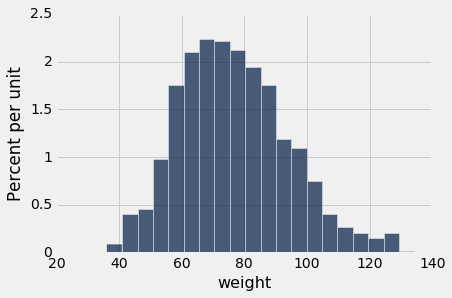

In [37]:
smokers.hist('weight', bins=20)

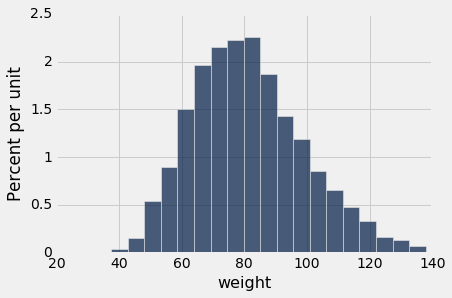

In [38]:
nosmokers.hist('weight', bins=20)

In [39]:
np.mean(nosmokers['weight'])-np.mean(smokers['weight'])

4.5292127574925019

## Permutation tests

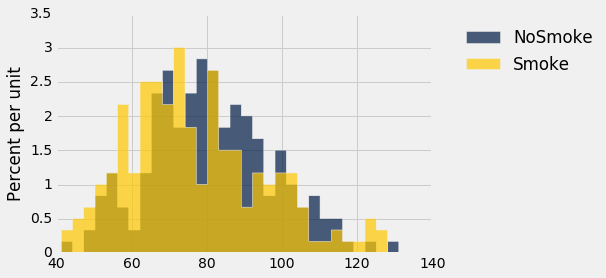

In [42]:
# Lets draw two samples of equal size
n_sample = 200
smoker_sample = smokers.sample(n_sample)
nosmoker_sample = nosmokers.sample(n_sample)
weight = Table().with_columns([('NoSmoke', nosmoker_sample['weight']),('Smoke', smoker_sample['weight'])])
weight.hist(overlay=True,bins=30,normed=True)

In [43]:
weight.stats(summary_ops)

statistic,NoSmoke,Smoke
min,41.2769,41.2769
firstQtile,70.08,64.1833
median,80.059,73.0283
mean,81.0979,76.7909
thirdQtile,70.08,64.1833
max,131.088,127.006
sum,16219.6,15358.2


Is the difference observed between these samples representative of the larger population?

In [44]:
combined = Table().with_column('all', np.append(nosmoker_sample['weight'],smoker_sample['weight']))

In [45]:
combined.num_rows

400

In [46]:
# permutation test, split the combined into two random groups, do the comparison of those
def getdiff():
    A,B = combined.split(n_sample)
    return (np.mean(A['all'])-np.mean(B['all']))

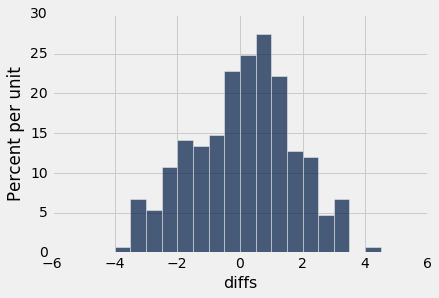

In [47]:
# Do the permutation many times and form the distribution of results
num_samples = 300
diff_samples = Table().with_column('diffs', [getdiff() for i in range(num_samples)])
diff_samples.hist(bins=np.arange(-5,5,0.5), normed=True)

The 4.5 kg difference is certainly not an artifact of the sample we started with.  The smokers definitely weigh less. At the same time, these are not light people in this study.  Better go back and understand what was the purpose of the study that led to the selection of these six thousand individuals.

## Other Factors

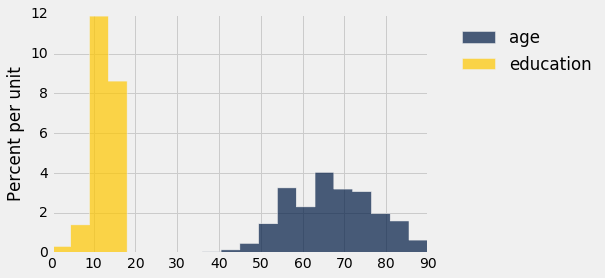

In [48]:
# A sense of the overall population represented - older
health.select(['age','education']).hist(bins=20)

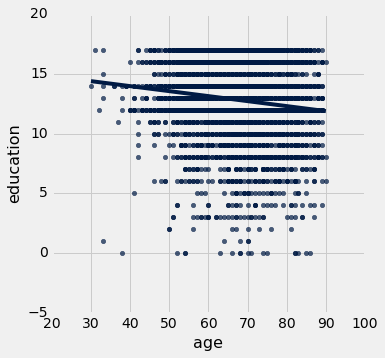

In [49]:
# How does education correlate with age?
health.select(['age','education']).scatter('age', fit_line=True)

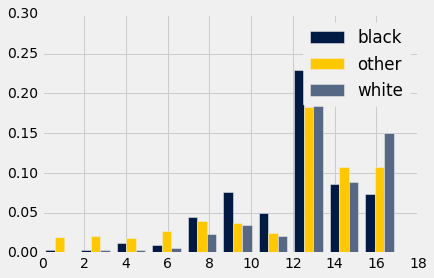

In [50]:
health.pivot_hist('race','education',normed=True)

In [51]:
# How are races represented in the dataset and how does hispanic overlay the three?
race = health.select(['race', 'hispanic'])   
race['count']=1
by_race = race.group('race',sum)
by_race['race frac'] = by_race['count sum']/np.sum(by_race['count sum'])
by_race['hisp frac'] = by_race['hispanic sum'] / by_race['count sum']
by_race

race,hispanic sum,count sum,race frac,hisp frac
black,10,766,0.120782,0.0130548
other,148,279,0.0439924,0.530466
white,297,5297,0.835225,0.0560695


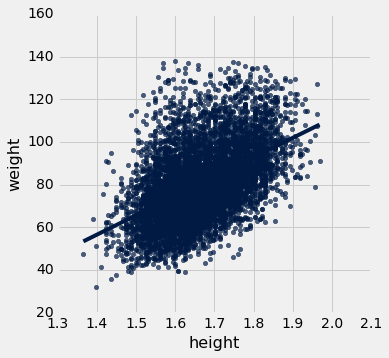

In [52]:
health.select(['height','weight']).scatter('height','weight',fit_line=True)